Accuracy: 0.8508771929824561
Confusion Matrix:
[[38  0  3  2  1  0  1  0  0  1]
 [ 1 51  3  1  0  3  3  0  0  0]
 [ 0  0 53  4  3  0  1  0  0  0]
 [ 1  0  4 43  6  0  6  0  0  0]
 [ 2  2  3  1 40  1  3  0  0  1]
 [ 1  0  1  0  0 43  0  1  1  0]
 [ 0  1  1  0  3  4 51  0  1  0]
 [ 0  0  0  0  0  0  0 63  0  0]
 [ 0  0  0  0  0  0  0  8 50  0]
 [ 0  2  1  0  0  1  0  2  0 53]]
ROC AUC: 0.9885522905619774


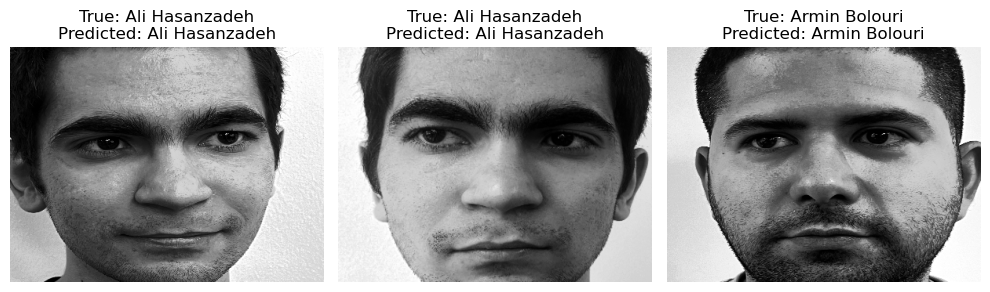

Model training and evaluation completed. Models and encoders are saved.


In [12]:
import os
import cv2
import numpy as np
from face_recognition import load_images, preprocess_image, detect_faces, extract_hog_features
from data_augmentation import augment_image
from model_training import train_svm, evaluate_model, visualize_results, save_model, load_model
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import tkinter as tk
from gui import FaceRecognitionApp
import joblib

# Constants
IMAGE_SIZE = (400, 300)
IMAGE_PATH = "Employee_Photos"

# Initialize face cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Load and preprocess images
data, labels = load_images(IMAGE_PATH, face_cascade)
data = [preprocess_image(img) for img in data]

# Augment images
augmented_data = []
augmented_labels = []
for img, label in zip(data, labels):
    augmented_images = augment_image(img)
    augmented_data.extend(augmented_images)
    augmented_labels.extend([label] * len(augmented_images))

# Convert to numpy arrays
data = np.array(augmented_data)
labels = np.array(augmented_labels)

# Extract HOG features
data_hog = [extract_hog_features(img) for img in data]
data_hog = np.array(data_hog)

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
joblib.dump(label_encoder, 'le.joblib')

# Split data and images separately
X_train, X_test, y_train, y_test = train_test_split(data_hog, labels_encoded, test_size=0.3, random_state=42)
_, X_test_images = train_test_split(data, test_size=0.3, random_state=42)

# Determine the number of features and classes
n_features = X_train.shape[1]
n_classes = len(np.unique(y_train))

# Set the number of components for LDA
n_components = min(n_features, n_classes - 1)

# Perform LDA for dimensionality reduction
lda = LDA(n_components=n_components)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)
joblib.dump(lda, 'lda.joblib')

# Train SVM model
svm_model = train_svm(X_train_lda, y_train)

# Save the trained model
model_filename = 'svm_model.joblib'
save_model(svm_model, model_filename)

# Evaluate model
accuracy, cm, roc_auc = evaluate_model(svm_model, X_test_lda, y_test, label_encoder)
print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{cm}")
print(f"ROC AUC: {roc_auc}")

# Visualize results
sample_indices = np.random.choice(len(X_test), 3, replace=False)
visualize_results(X_test_images[sample_indices], label_encoder.inverse_transform(y_test[sample_indices]), label_encoder.inverse_transform(svm_model.predict(X_test_lda[sample_indices])))

print("Model training and evaluation completed. Models and encoders are saved.")

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import tkinter as tk
from gui import FaceRecognitionApp

# Start GUI for face recognition
if __name__ == "__main__":
    root = tk.Tk()
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    svm_model = joblib.load('svm_model.joblib')
    lda = joblib.load('lda.joblib')
    label_encoder = joblib.load('le.joblib')
    app = FaceRecognitionApp(root, face_cascade, svm_model, lda, label_encoder)
    root.mainloop()